# Methods of De-treding
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [1]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import string
from typing import Dict
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

import os
import sys

from typing import Optional, Callable, List, Tuple

warnings.filterwarnings('ignore')

In [2]:
from numpy.typing import ArrayLike

In [3]:
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import utils

import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon

logger = utils.get_notebook_logger()

In [4]:
notebook_number='00'

In [5]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0] # 0, 1, 2 3, 4, 5, 6, 7
experiment_params

{'variable': 'tas', 'mask': None, 'hemisphere': 'global'}

# Loading Data

## ZECMIP

In [6]:
experiment_zec_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', '4xCO2', '*.nc')).compute()

picontrol_zec_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()
experiment_zec_ds

<xarray.Dataset>
Dimensions:  (time: 330, lat: 96, lon: 192, model: 8)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0330-12-31 00:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.1 265.1

In [7]:
experiment_zec_ds_smean, picontrol_zec_ds_smean = sn.calculate_global_value(
    experiment_zec_ds, picontrol_zec_ds,experiment_params["variable"])

(None, None)
tas, 

## Abrupt 4x

In [8]:
control_abrupt_ds = open_ds.open_experiment_files(experiment_params, ExperimentTypes.CONTROL)
abrupt4x_ds = open_ds.open_experiment_files(experiment_params, ExperimentTypes.ABRUPT4X)

- Removing first 10 steps


In [9]:
abrupt4x_ds['time'] = range(len(abrupt4x_ds.time.values))
control_abrupt_ds['time'] = range(len(control_abrupt_ds.time.values))

In [10]:
abrupt4x_ds_smean, control_abrupt_ds_smean = sn.calculate_global_value(
    abrupt4x_ds, control_abrupt_ds, experiment_params["variable"])

abrupt4x_ds_smean

(None, None)
ccsm3, cesm104, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 

<xarray.Dataset>
Dimensions:   (time: 5900)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 ... 5893 5894 5895 5896 5897 5898 5899
    height    float64 2.0
Data variables:
    ccsm3     (time) float32 2.281 2.565 2.733 2.643 2.751 ... nan nan nan nan
    cesm104   (time) float32 1.181 1.599 1.98 2.198 ... 6.841 6.631 6.753 6.895
    cnrmcm61  (time) float32 1.242 1.925 2.524 2.965 3.297 ... nan nan nan nan
    hadcm3l   (time) float64 1.69 2.179 2.517 2.854 3.273 ... nan nan nan nan
    ipslcm5a  (time) float32 1.275 1.774 2.037 2.391 2.741 ... nan nan nan nan
    mpiesm11  (time) float32 0.984 1.628 2.228 2.489 2.941 ... nan nan nan nan
    mpiesm12  (time) float32 1.361 1.988 2.466 2.726 2.842 ... nan nan nan nan

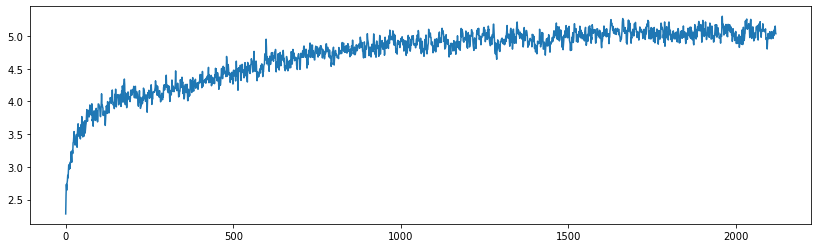

In [11]:
fig = plt.figure(figsize=(14,4))
plt.plot(abrupt4x_ds_smean.ccsm3.values)

# Calculations

## Functions

In [12]:
def loess_detrend(x:ArrayLike, y:ArrayLike, window:int, debug=False):
    if debug: print(window)
    return xca.SignalToNoise.loess_filter(y, window=window)

In [13]:
def poly_trend(x:ArrayLike, y:ArrayLike, deg:int, debug=False):
    polynomial_coefficients = np.polyfit(x, y, deg=deg)
    trend = np.polyval(polynomial_coefficients, x)
    return trend

In [14]:
def detrend_data_over_range(y_input:np.ndarray, test_parameters:tuple, 
                            func1d: Callable, x:np.ndarray=None, 
                           debug:bool=False)-> Dict[str, Dict[str, np.ndarray]]:
    dict_to_return = {}
    x = np.arange(len(y_input)) if x is None else x
    for param in test_parameters:
        if debug: print(param)
        trend = func1d(x, y_input, param, debug)
        detrended_data = y_input-trend
        std = np.std(detrended_data)
        dict_to_return[param] = {'trend': trend, 'detrended_data': detrended_data, 'x':x, 'data':y_input,
                                'noise': std}
        
    return dict_to_return

In [15]:
def create_detrended_da(detrended_dict:dict, empty_da:xr.DataArray)->xr.DataArray:
    da_stor = []
    for key in detrended_dict:
        detended_da = empty_da + detrended_dict[key]['detrended_data']
        da_stor.append(detended_da)
    detrended_da_total = xr.concat(da_stor, pd.Index(list(detrended_dict.keys()), name='param'))
    return detrended_da_total

## Data Selection

In [16]:
dir(LocationsLatLon)

['ARCTIC',
 'BEIJING',
 'BUENOS_AIRES',
 'CENTRAL_PACIFIC',
 'ECHINA_SEA',
 'EPACIFIC',
 'JAKARTA',
 'KINSHASA',
 'LONDON',
 'MELBOURNE',
 'NATLANTIC',
 'NEW_YORK',
 'SOUTHERN_OCEAN',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [157]:
PROFILE_SELECTOR_DICT = {
    'zec': {
        'global': {'pi': picontrol_zec_ds_smean.tas, 'exp': experiment_zec_ds_smean.tas},
        'local': {'pi': picontrol_zec_ds.tas, 'exp': experiment_zec_ds.tas}},
    'abrupt': {
        'global': {'pi': control_abrupt_ds_smean, 'exp': abrupt4x_ds_smean},
        'local': {'pi': control_abrupt_ds, 'exp': abrupt4x_ds}}}

In [394]:
profile = 'abrupt' # abrupt zec
region = 'local' #  global local
model1 = 'ccsm3'
model2 = 'CESM2'

In [395]:
experiment_da = PROFILE_SELECTOR_DICT[profile][region]['exp']
picontrol_da = PROFILE_SELECTOR_DICT[profile][region]['pi']

In [396]:
LocEnum = LocationsLatLon.ARCTIC

In [397]:
if 'model' in list(experiment_da.coords):
    experiment_da = experiment_da.sel(model=model2)
    picontrol_da = picontrol_da.sel(model=model2)
else:
    experiment_da = experiment_da[model1]
    picontrol_da = picontrol_da[model1]

In [398]:
experiment_da

<xarray.DataArray 'ccsm3' (time: 5900, lat: 72, lon: 144)>
array([[[-36.435654 , -36.810577 , -36.812454 , ..., -35.716965 ,
         -36.06871  , -36.07048  ],
        [-35.837067 , -36.22055  , -36.604767 , ..., -34.769394 ,
         -35.109344 , -35.46666  ],
        [-34.384064 , -35.11458  , -35.85515  , ..., -32.33751  ,
         -32.988937 , -33.675507 ],
        ...,
        [-12.759216 , -12.608215 , -12.4823   , ..., -13.467957 ,
         -13.204346 , -12.957886 ],
        [-13.296204 , -13.2247925, -13.16626  , ..., -13.574799 ,
         -13.471985 , -13.378601 ],
        [-13.482361 , -13.438843 , -13.43866  , ..., -13.605469 ,
         -13.541931 , -13.5416565]],

       [[-35.263382 , -35.614853 , -35.616608 , ..., -34.589706 ,
         -34.91957  , -34.92122  ],
        [-34.62381  , -34.97757  , -35.333176 , ..., -33.626434 ,
         -33.94223  , -34.2787   ],
        [-33.040787 , -33.71428  , -34.39067  , ..., -31.142502 ,
         -31.74208  , -32.383392 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 5893 5894 5895 5896 5897 5898 5899
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height   float64 ...

In [399]:
if region == 'local':
    lat, lon = LocEnum.value
    name = LocEnum.name.lower().capitalize()
    experiment_da = experiment_da.sel(lat=lat, lon=lon, method='nearest').dropna(dim='time')
elif region == 'global':
    lat, lon = ('global', '')
    name='global'
    experiment_da = experiment_da.dropna(dim='time')

In [400]:
print(f'{profile=}, {name=}, {lat=}, {lon=}, len = {len(experiment_da.time.values)}')

profile='abrupt', name='Arctic', lat=76, lon=100, len = 2120


In [401]:
experiment_da

<xarray.DataArray 'ccsm3' (time: 2120)>
array([ -9.903748 , -12.198181 ,  -8.645203 , ...,  -8.9366455,
        -6.426758 ,  -7.6868286], dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 2113 2114 2115 2116 2117 2118 2119
    lon      float32 101.2
    lat      float32 76.25
    height   float64 ...

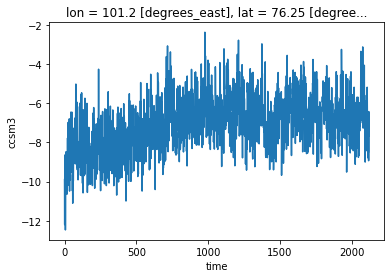

In [402]:
experiment_da.plot()

## Execution

In [403]:
empty_da = xr.zeros_like(experiment_da)
empty_no_abtupt_da = xr.zeros_like(experiment_da[100:])

In [404]:
test_values_array = experiment_da.values
x = np.arange(len(test_values_array))

In [405]:
poly_degees = range(1, 10)

poly_dict = detrend_data_over_range(test_values_array, poly_degees, poly_trend, x)

In [406]:
WINDOW_MAPPING = {'abrupt': (5, 10, 20, 50, 100, 150, 200, 250, 500), 
                 'zec': (5, 10, 20, 50, 100)}

windows = WINDOW_MAPPING[profile]
windows

(5, 10, 20, 50, 100, 150, 200, 250, 500)

In [407]:

loess_dict = detrend_data_over_range(y_input=test_values_array, test_parameters=windows,
                                     func1d=loess_detrend, x=x)

In [408]:
experiment_signal = experiment_da.sn.calculate_rolling_signal(window=20)

In [409]:
poly_ds = create_detrended_da(poly_dict, empty_da)

poly_noise_ds = poly_ds.sn.calculate_rolling_noise(window=20)
poly_sn_ds = experiment_signal/poly_noise_ds
poly_sn_static_noise_ds = experiment_signal/poly_ds.std(dim='time')

In [410]:
loess_ds = create_detrended_da(loess_dict, empty_da)

loess_noise_ds = loess_ds.sn.calculate_rolling_noise(window=20)

loess_sn_ds = experiment_signal/loess_noise_ds
loess_sn_static_noise_ds = experiment_signal/loess_ds.std(dim='time')

In [411]:
if profile == 'abrupt':
    print('Expanding analysis')
    experiment_signal_no_abrupt = experiment_da.isel(
        time=slice(100, None)).sn.calculate_rolling_signal(window=20)
    
    poly_no_abrupt_dict = detrend_data_over_range(test_values_array[100:], poly_degees, poly_trend, x[100:])
    loess_no_abrupt_dict = detrend_data_over_range(test_values_array[100:], windows, loess_detrend, x[100:])

    poly_no_abrupt_ds = create_detrended_da(poly_no_abrupt_dict, empty_no_abtupt_da)

    poly_no_abrupt_noise_ds = poly_no_abrupt_ds.sn.calculate_rolling_noise(window=20)
    poly_no_abrupt_sn_ds = experiment_signal_no_abrupt/poly_no_abrupt_noise_ds

    loess_no_abrupt_ds = create_detrended_da(loess_no_abrupt_dict, empty_no_abtupt_da)

    loess_no_abrupt_noise_ds = loess_no_abrupt_ds.sn.calculate_rolling_noise(window=20)
    loess_no_abrupt_sn_ds = experiment_signal_no_abrupt/loess_no_abrupt_noise_ds
else:
    print('No calculations required. This is not abrupt')

Expanding analysis


## Plots

### Functions

In [412]:
def create_multi_detrend_plot(detrend_dict: dict, height_factor:float=4,
                              noise_ds:xr.DataArray=None):
    num_subplots = len(detrend_dict)
    fig = plt.figure(figsize=(15, height_factor*len(detrend_dict)))
    num_subplots = num_subplots*3 if isinstance(noise_ds, xr.DataArray) else num_subplots
    height_ratios = [1, .4, .6] * int(num_subplots/3)
    gs = gridspec.GridSpec(num_subplots,1, height_ratios=height_ratios, hspace=0) # prev .7
    
    plot_num = 0
    for key, values in detrend_dict.items():

        ax = fig.add_subplot(gs[plot_num])
        ax.plot(values['x'], values['trend'], label='poly fit', color='red')
        ax.plot(values['x'], values['data'], label='raw', zorder=-1, color='blue')
        ax.legend(bbox_to_anchor=[-.06, .8])
        ax.set_ylabel('Temperature')
        
        noise = values['noise']
        ax.set_title(f'{key} (Average Noise = {noise:.2f})')

        ax2 = ax.twinx()
        ax2.plot(values['x'],values['detrended_data'], label='detred', alpha=0.6, color='green')
        ax2.legend(bbox_to_anchor=[1.08, 0.8])

        if isinstance(noise_ds, xr.DataArray):
            plot_num += 1
            ax3 = fig.add_subplot(gs[plot_num])
            noise_ds.sel(param=key).plot(ax=ax3, label='noise')
            ax3.set_ylim([np.nanmin(noise_ds.values), np.nanmax(noise_ds.values)*1.05])
            ax3.set_title('Noise')
            ax.set_xticklabels([])
            ax.set_xlabel('')
            plot_num += 1
        plot_num += 1
        
    return fig, [ax, ax2]

In [413]:
def plot_all_lines(ax:Axes, da:xr.DataArray, coord:str, legend_title:Optional=None):
    coord_vals = da[coord].values
    listed_colormap = cm.get_cmap('BrBG', len(coord_vals))(np.arange(len(coord_vals)))

    x_data = da.time.values
    for i,c in enumerate(coord_vals):
        da_sel = da.loc[{coord:c}]
        ax.plot(x_data, da_sel.values, label=c, color=listed_colormap[i])
        
    leg = ax.legend(loc='best', title=legend_title, ncol=len(coord_vals))
    # bbox_to_anchor=[0.8, 1.1]

In [414]:
def __fill_plots(fig, gs, da_origin, da_sn, da_noise, plot_start_num:int=0, legend_title:Optional[str]=None):
    
    ylabel_params = dict(labelpad=42, fontsize=16, rotation=0)

    ax1 = fig.add_subplot(gs[plot_start_num+0])
    ax1.plot(da_origin.time.values, da_origin.values, label='GMST', alpha=0.6, zorder=-100)
    ax1.set_ylabel('Temperature', **ylabel_params)
    
    ax2 = fig.add_subplot(gs[plot_start_num+1])
    plot_all_lines(ax2, da_sn.squeeze(), coord='param', legend_title=legend_title)
    ax2.set_ylabel('S/N', **ylabel_params)
    
    ax3 = fig.add_subplot(gs[plot_start_num+2])
    plot_all_lines(ax3, da_noise.squeeze(), coord='param')
    ax3.set_ylabel('Noise', **ylabel_params)

In [415]:
def plot_multi_sn_and_noise(da_sn:xr.DataArray, da_noise, da_origin:xr.DataArray,
                            coord:str='param', legend_title:Optional=None,
                           x_subsets:List[Tuple]=None) -> [plt.figure, Axes]:
    
    # If there are no xsubsets
    base_x_subsets = (None, None)
    if x_subsets:
        x_subsets.insert(0, base_x_subsets)
    else: 
        x_subsets = [base_x_subsets]
                             
    fig = plt.figure(figsize=(15, 10*len(x_subsets)))
    # Set of three plots - 1 for each dataset, and one to seperate with
    # the next set
    height_ratios = [0.6, 1, 1, 0.4] * len(x_subsets)
    # Don't need seperator at the end
    height_ratios = height_ratios[:-1]
    gs = gridspec.GridSpec(len(height_ratios), 1, height_ratios=height_ratios, hspace=0)
        
    plot_index = 0
    for xlims in x_subsets:
        print(xlims)
        isel_kwargs = dict(time=slice(*xlims))
        __fill_plots(fig, gs, da_origin.isel(isel_kwargs), da_sn.isel(isel_kwargs), 
                     da_noise.isel(isel_kwargs), plot_index)
        plot_index += 4

    
    return fig, gs

In [416]:
def compare_sn_values(rolling_ds, static_ds, coord:str='param'):
    
    
    assert all(rolling_ds.param.values ==  static_ds.param.values)
    coord_values = rolling_ds.param.values
    
    fig = plt.figure(figsize=(15, 4 * len(coord_values)))
    height_ratios = [1, 0.4, 0.4] * int(len(coord_values))
    gs = gridspec.GridSpec(len(height_ratios), 1, height_ratios=height_ratios, hspace=0)
    
    ylabel_params = dict(labelpad=42, fontsize=14, rotation=0)
    
    axes = []
    plot_num=0
    for c in coord_values:
        ax = fig.add_subplot(gs[plot_num])
        rolling_ds_c = rolling_ds.loc[{coord:c}].squeeze()
        static_ds_c = static_ds.loc[{coord:c}].squeeze()
        
        diff = rolling_ds_c - static_ds_c
        rmse = float(np.mean(np.sqrt(np.power(diff, 2))))
        
        ax.plot(rolling_ds_c.time.values, rolling_ds_c.values, label='Rolling')
        ax.plot(static_ds_c.time.values, static_ds_c.values, label='Static')
        
        ax.set_title(f'{c} (RMSE - {rmse:.2f})')
        ax.set_ylabel('S/N', **ylabel_params)
        leg = ax.legend(loc='upper right', title='Noise Type')
        
        plot_num += 1
        ax2 = fig.add_subplot(gs[plot_num])
        ax2.plot(diff.time.values, np.abs(diff.values), color='red')
        ax2.set_ylabel('Abs\nDifference', **ylabel_params)
        leg_twinx = ax2.legend(loc='upper right', title= 'Abs Difference')
        ax2.set_ylim([0, 4.1])
        plot_num+=2
        
        axes.append(ax)
    return fig, axes

### Execution

In [417]:
save_tag = f'{profile}_{model}_{name}'
save_tag

'abrupt_ccsm3_Arctic'

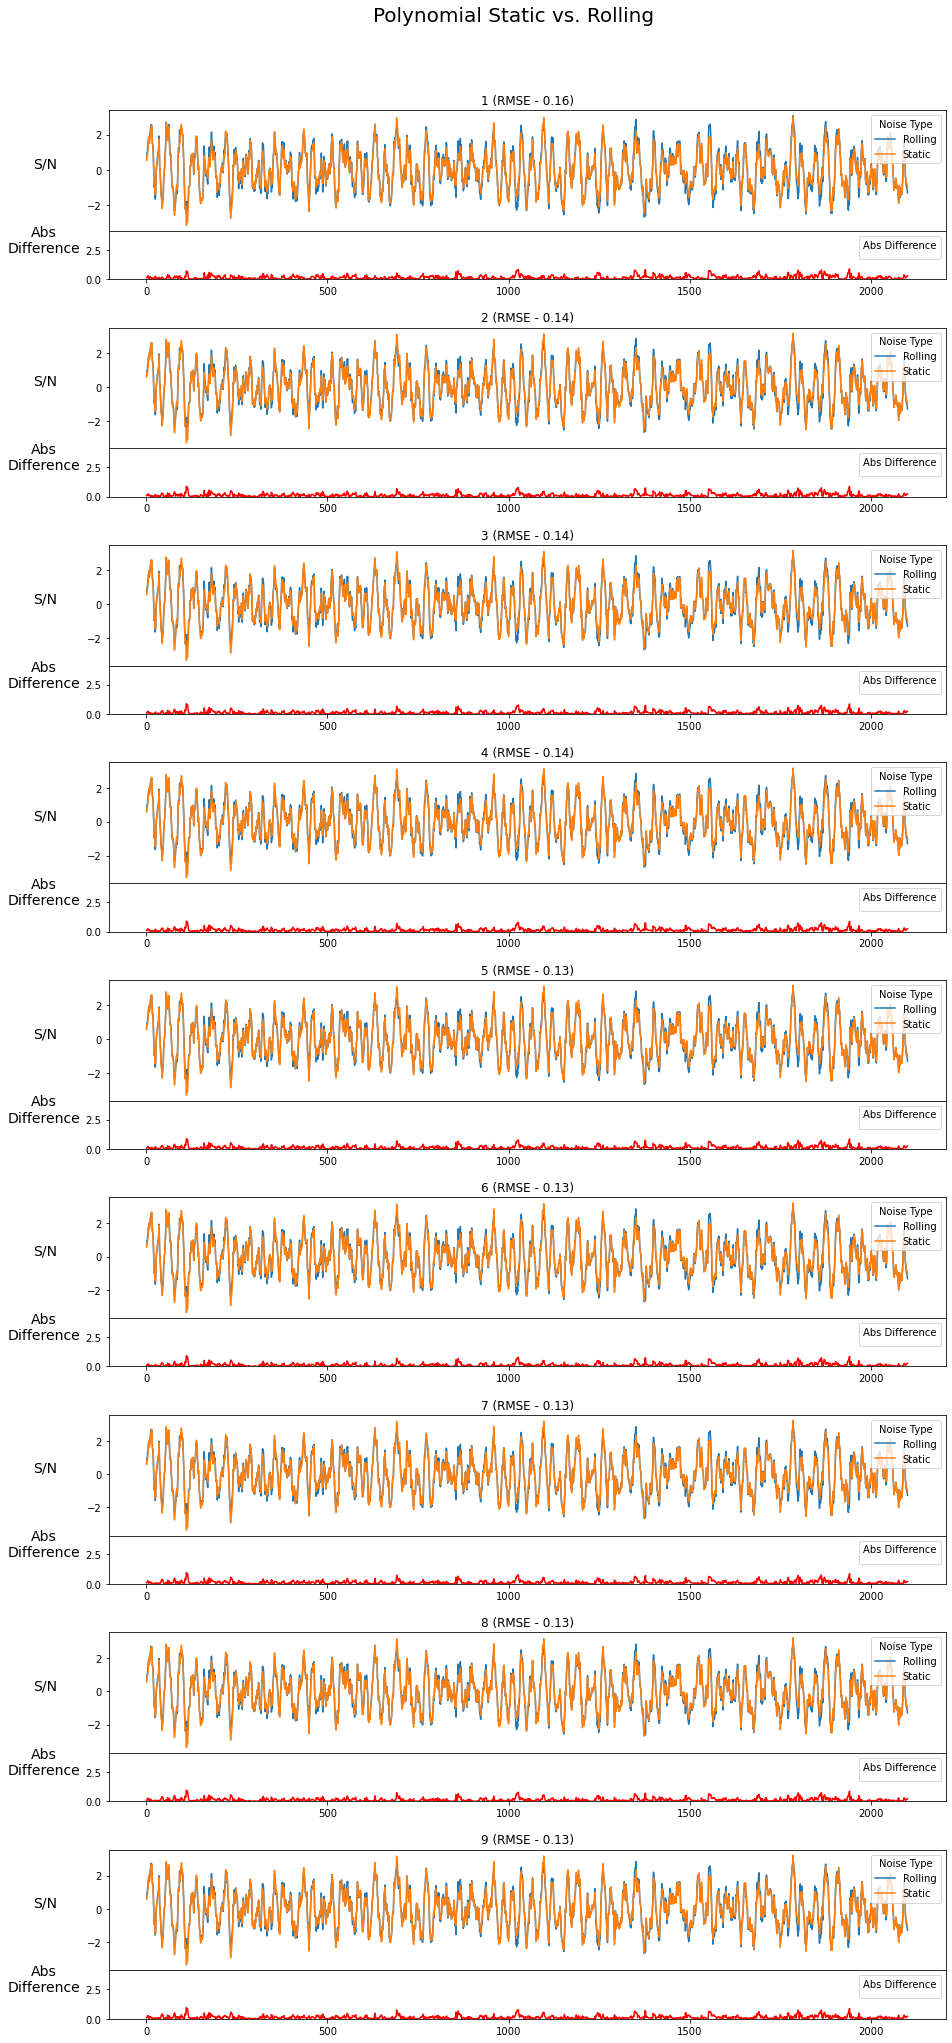

In [418]:
fig, axes = compare_sn_values(poly_sn_ds, poly_sn_static_noise_ds)

fig.suptitle('Polynomial Static vs. Rolling', fontsize=20, y=.92)
fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,
    f'methods_00_{save_tag}_polynomial_rolling_vs_sn_comp.png'),
           dpi=600)

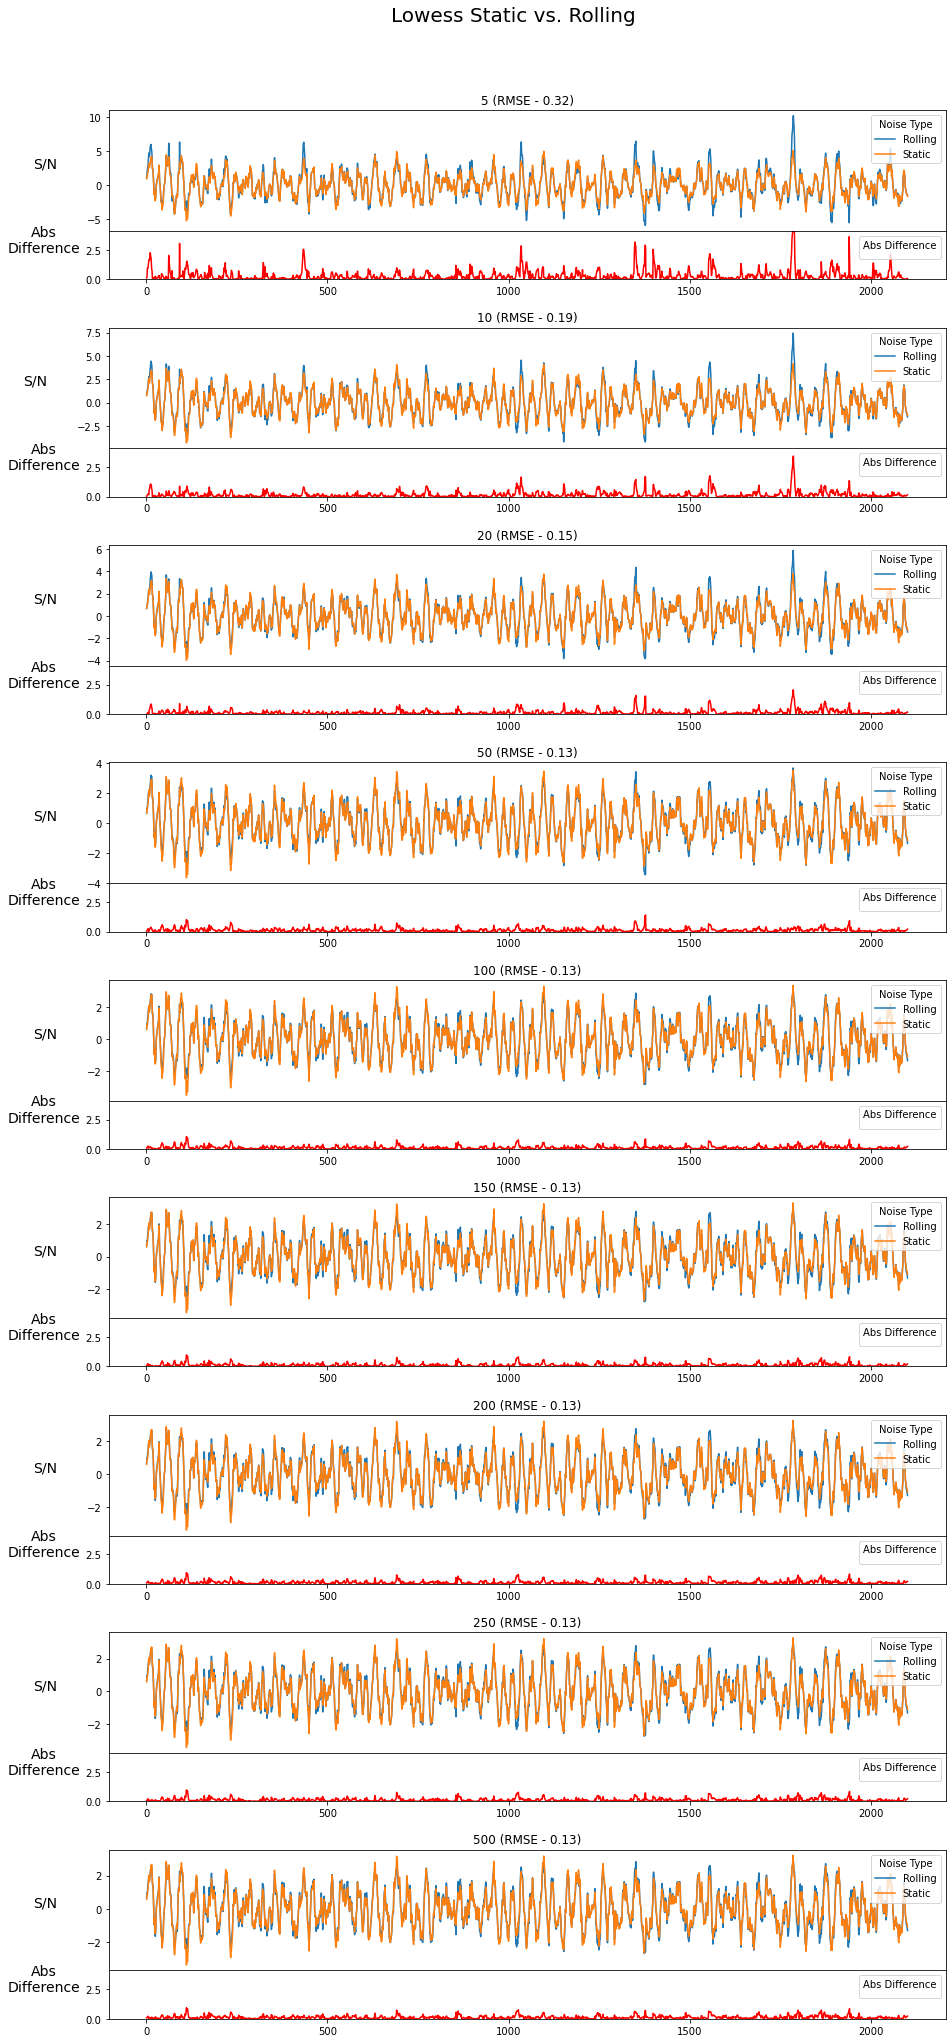

In [419]:
fig, gs = compare_sn_values(loess_sn_ds, loess_sn_static_noise_ds)

fig.suptitle('Lowess Static vs. Rolling', fontsize=20, y=.92)
fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,
    f'methods_00_{save_tag}_lowess_rolling_vs_sn_comp.png'),
           dpi=600)

In [420]:
x_subsets_input = [(None, 100)] if profile == 'abrupt' else None
x_subsets_input

[(None, 100)]

(None, None)
(None, 100)


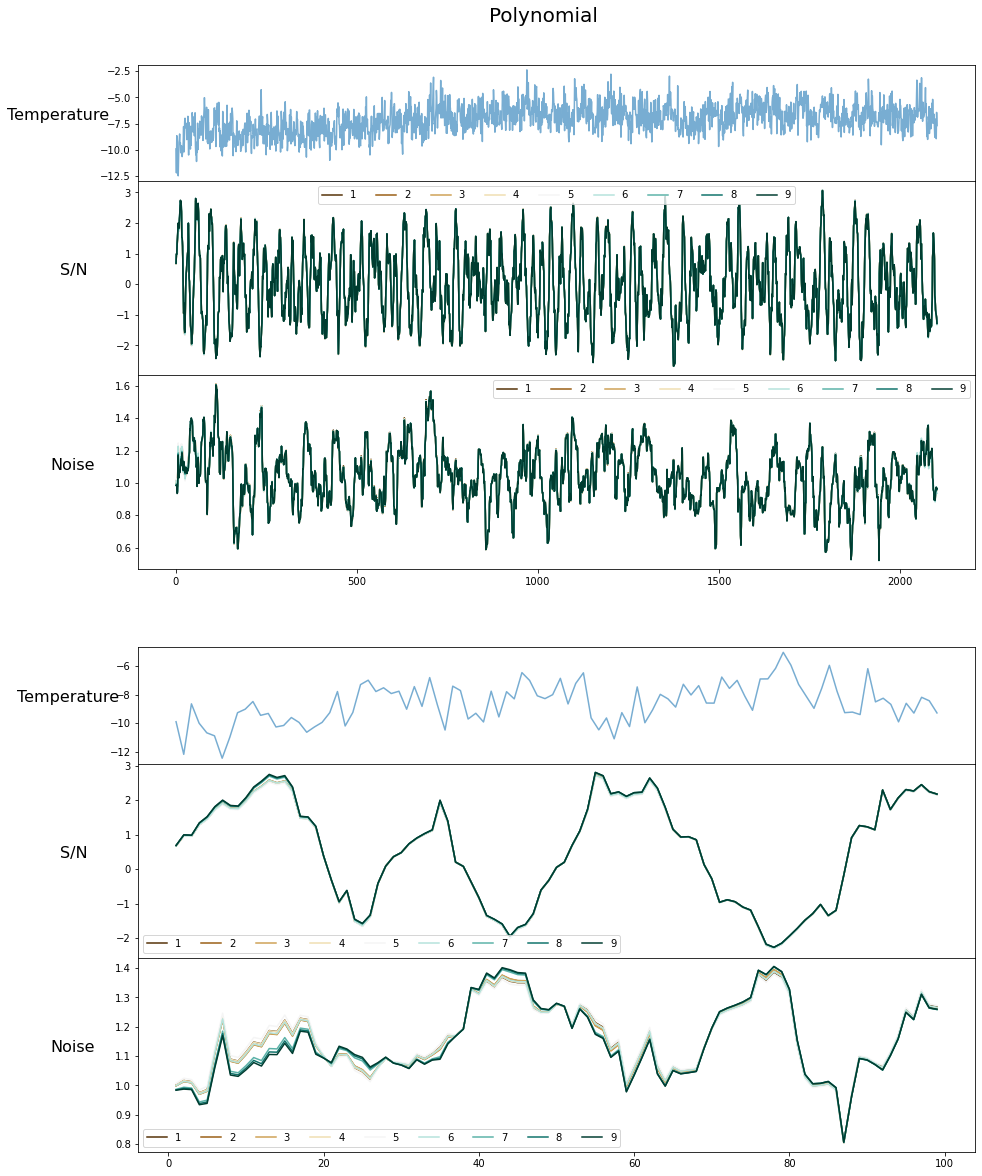

In [421]:
fig, gs = plot_multi_sn_and_noise(poly_sn_ds, poly_noise_ds, experiment_da, x_subsets=x_subsets_input)
fig.suptitle('Polynomial', fontsize=20, y=.92);

fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,f'methods_00_{save_tag}_polynomial_detrend_sn.png'),
           dpi=600)

In [422]:
x_subsets_input = [(None, 100)] if profile == 'abrupt' else None

(None, None)
(None, 100)


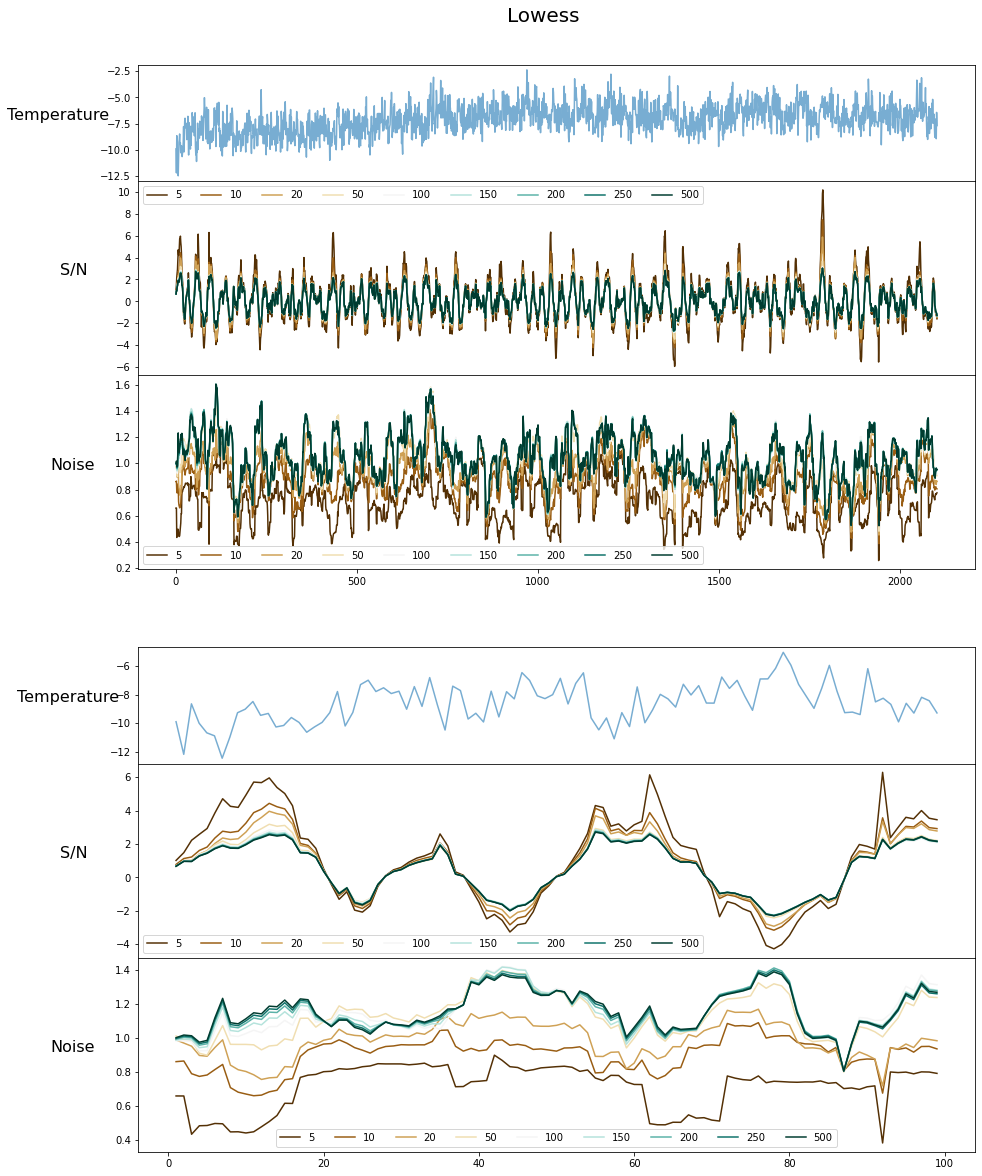

In [423]:
fig, axes = plot_multi_sn_and_noise(loess_sn_ds, loess_noise_ds, experiment_da, x_subsets=x_subsets_input)

fig.suptitle('Lowess', fontsize=20, y=.92)
fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,f'methods_00_{save_tag}_lowess_detrend_sn.png'),
           dpi=600)

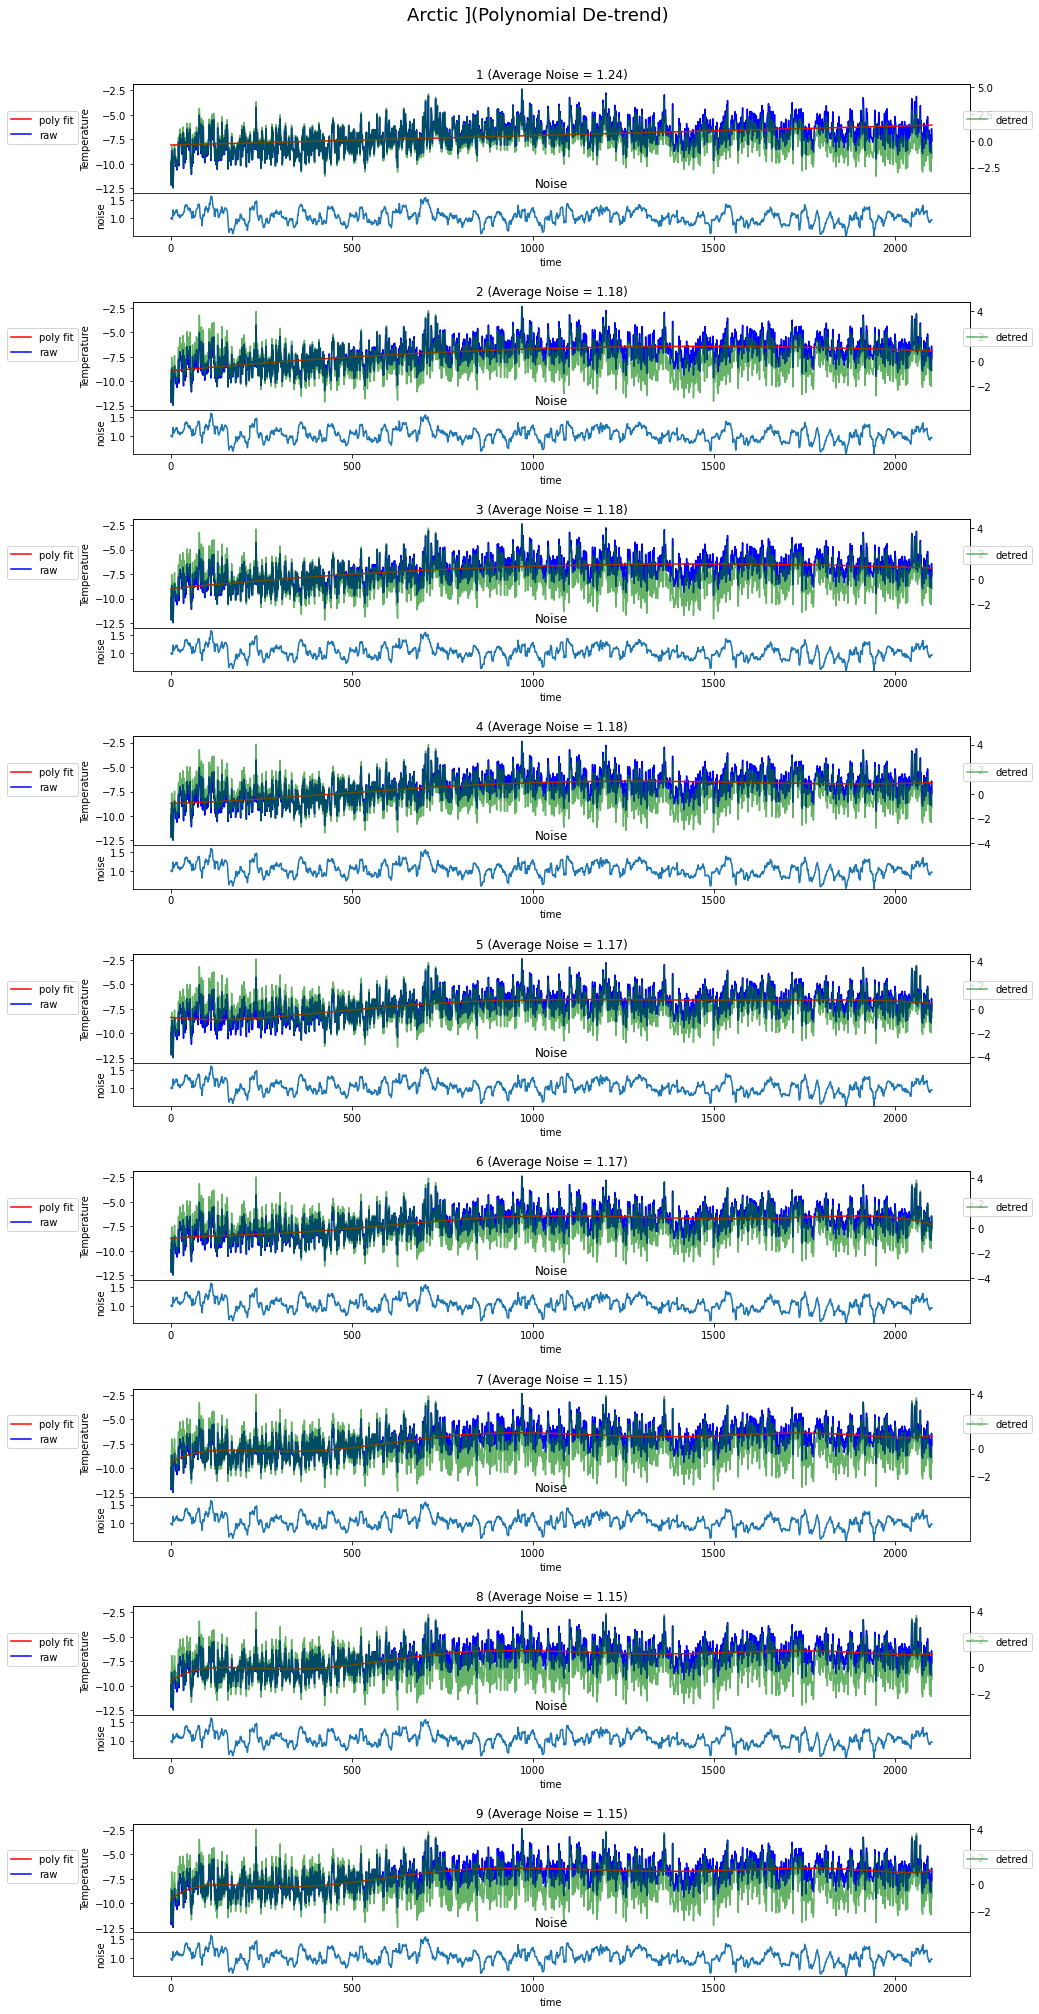

In [424]:
fig, axes = create_multi_detrend_plot(poly_dict, noise_ds=poly_noise_ds)
fig.suptitle(f'{name} ](Polynomial De-trend)', y=.91, fontsize=18)

fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,f'methods_00_{save_tag}_polynomial_detrend.png'),
           dpi=600)

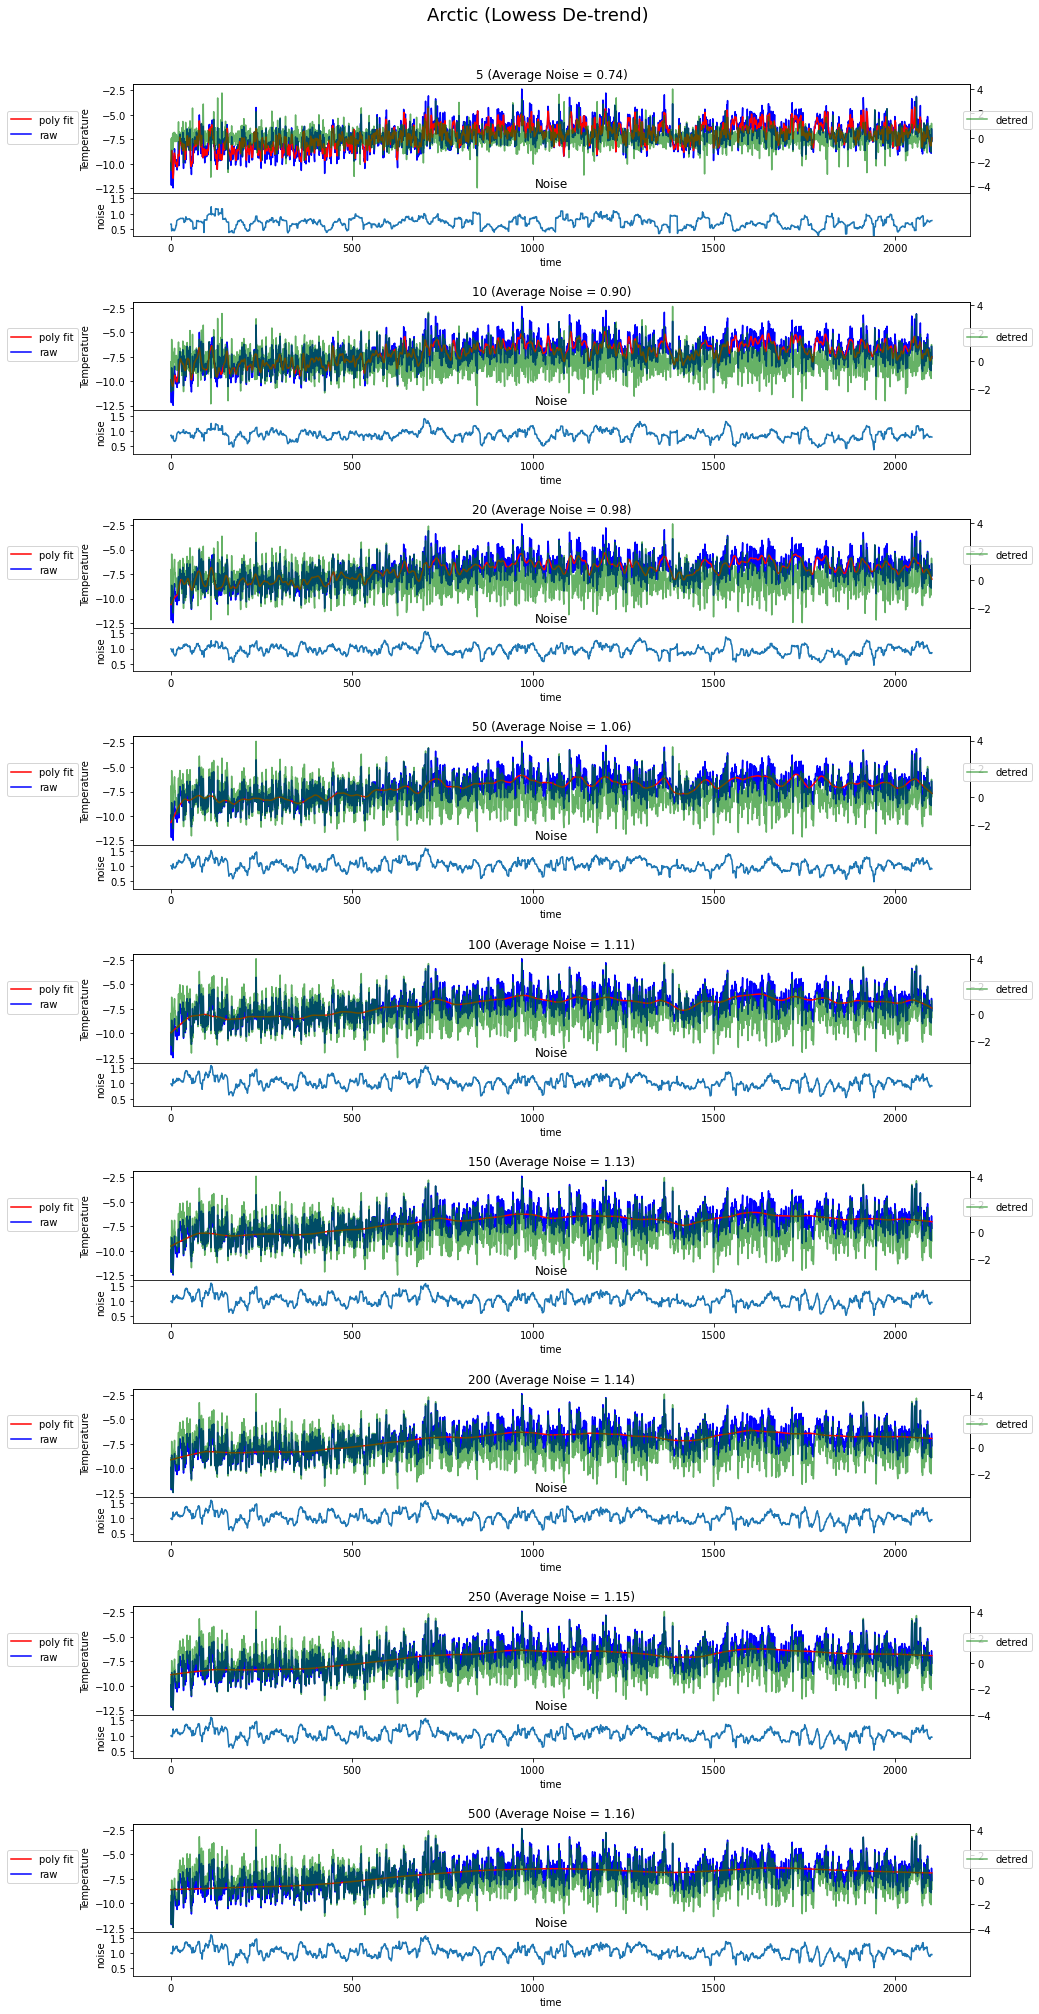

In [425]:
fig, axes = create_multi_detrend_plot(loess_dict, noise_ds=loess_noise_ds)

fig.suptitle(f'{name} (Lowess De-trend)', y=.91, fontsize=18)

fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,f'methods_00_{save_tag}_lowess_detrend.png'),
           dpi=600)

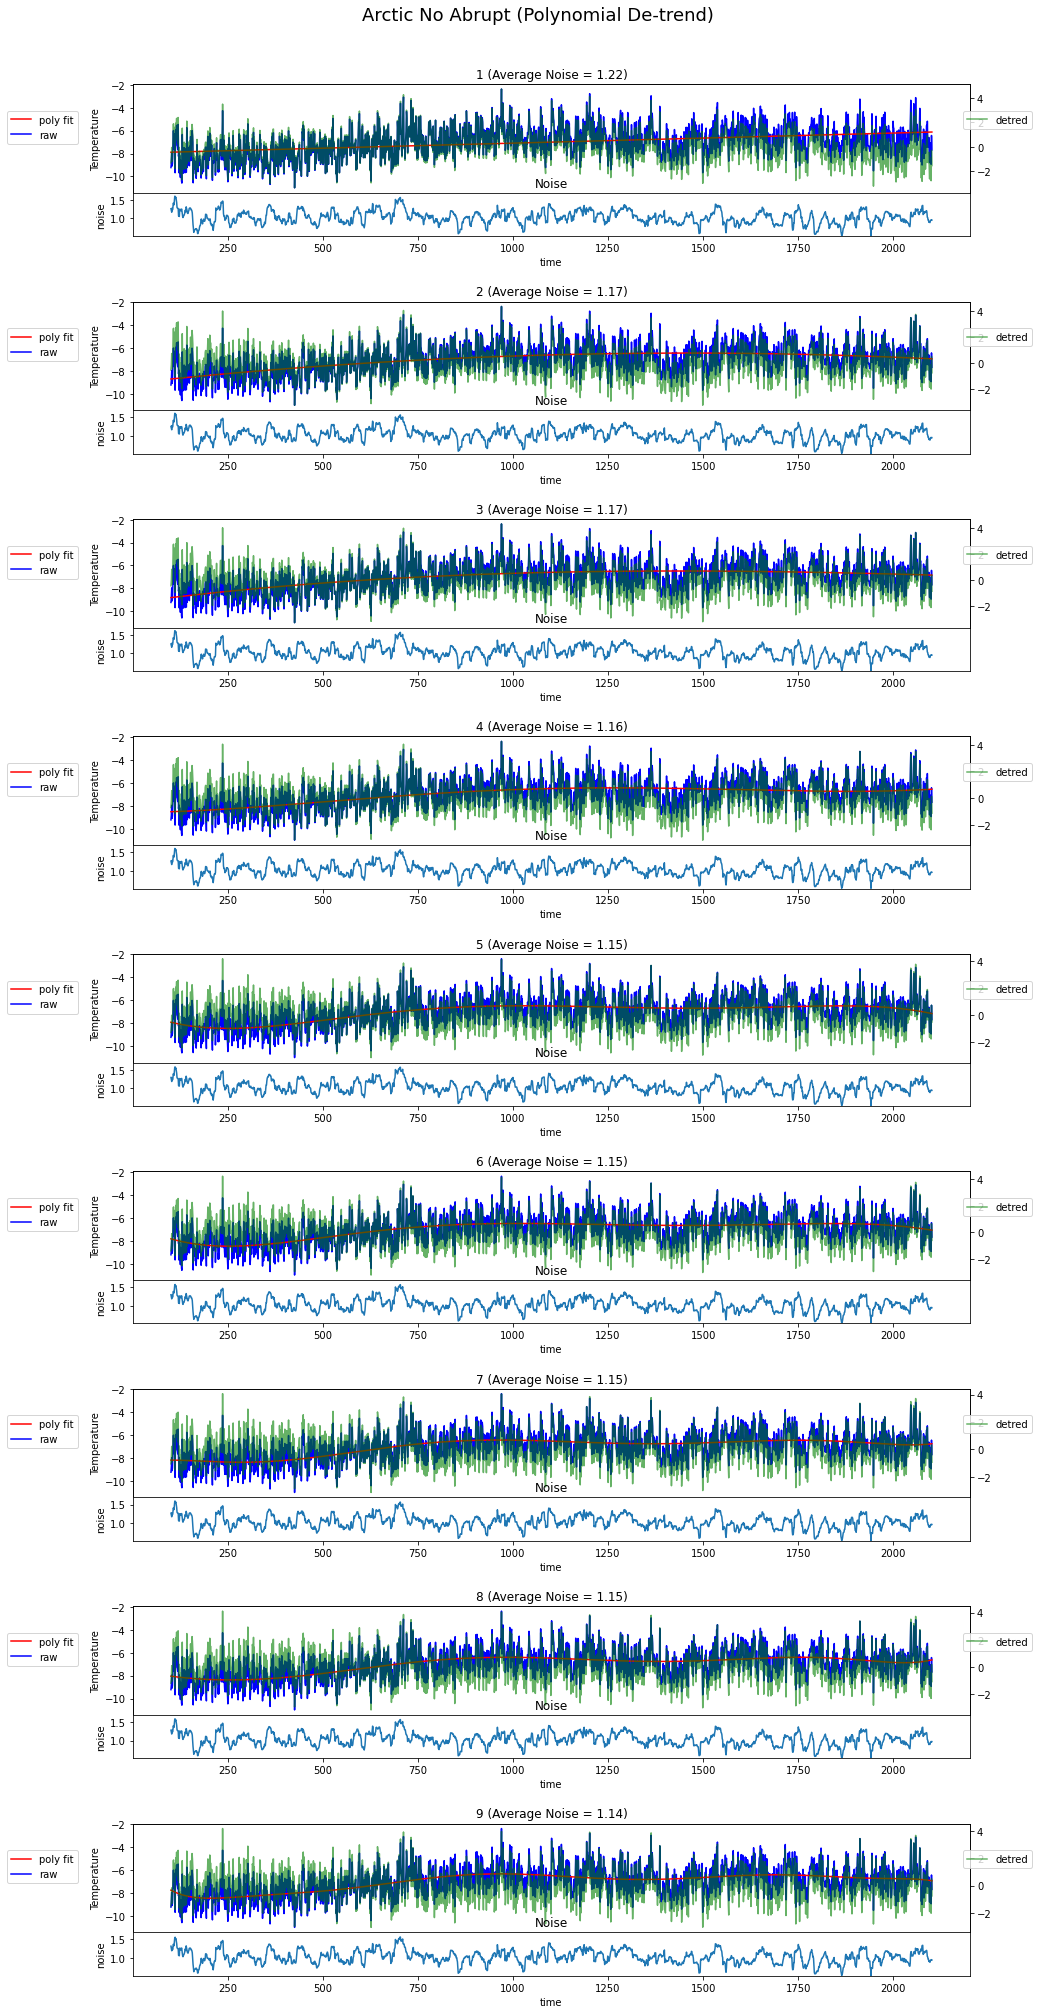

In [426]:
assert profile == 'abrupt' # Do not run following cells if using zec profile
fig, axes = create_multi_detrend_plot(poly_no_abrupt_dict, noise_ds=poly_no_abrupt_noise_ds)

fig.suptitle(f'{name} No Abrupt (Polynomial De-trend)', y=.91, fontsize=18)
fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,f'methods_00_{save_tag}_polynomial_detrend_no_abrupt.png'),
           dpi=600)

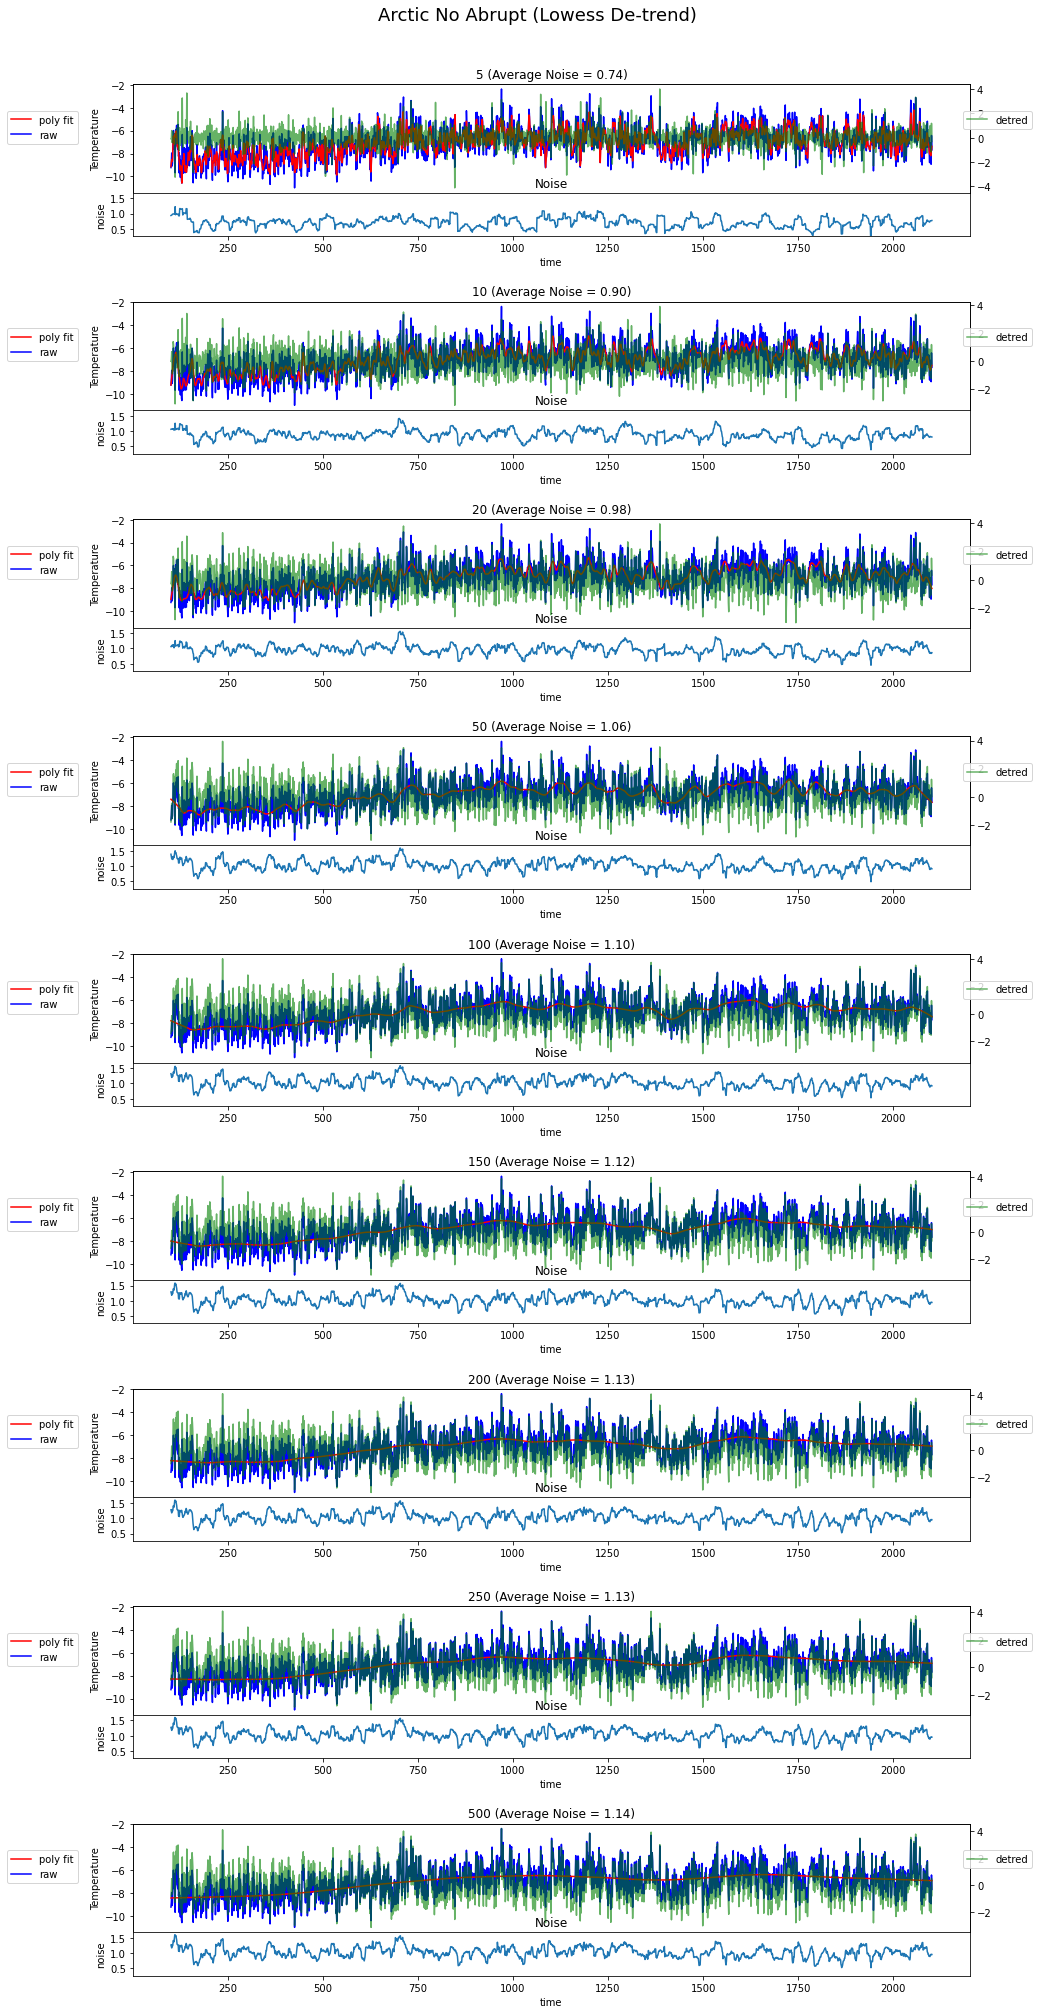

In [427]:
assert profile == 'abrupt' # Do not run following cells if using zec profile
fig, axes = create_multi_detrend_plot(loess_no_abrupt_dict, noise_ds=loess_no_abrupt_noise_ds)

fig.suptitle(f'{name} No Abrupt (Lowess De-trend)', y=.91, fontsize=18)

fig.savefig(os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,f'methods_00_{save_tag}_lowess_detrend_no_abrupt.png'),
           dpi=600)